In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
df_wide_raw = pd.read_excel("TRABAJO FINAL/DATA/Libro1.xlsx")

In [14]:
# ==========================================
# PASO 1: Configuración y carga del CSV WIDE
# ==========================================
df_wide_raw = pd.read_excel("TRABAJO FINAL/DATA/Libro1.xlsx")
RUTA_CSV = "CPI_wide_2012_2024.csv"   # <-- CAMBIA al nombre real de tu archivo
SEED = 42
np.random.seed(SEED)

# Años disponibles en tu base (2012 a 2024)
YEARS = list(range(2012, 2025))

# Splits temporales (modelo más adelante)
TRAIN_YEARS = list(range(2012, 2022))  # 2012-2021
VALID_YEARS = [2022, 2023]
TEST_YEARS  = [2024]                   # base para predecir 2025



# ---------- Registro de nombres ----------
NOMBRES_DATAFRAMES = ["df_wide_raw"]
NOMBRES_VARIABLES = {
    "ID": ["Country / Territory", "ISO3", "Region"],
    "POR_ANIO": {
        "score": "CPI score YYYY / CPI Score YYYY",
        "rank":  "Rank YYYY (solo 2017-2024)",
        "sources": "Sources YYYY",
        "se": "Standard error YYYY"
    }
}

print("Cargado df_wide_raw con forma:", df_wide_raw.shape)
print("Columnas (primeras 10):", list(df_wide_raw.columns)[:10])


Cargado df_wide_raw con forma: (181, 50)
Columnas (primeras 10): ['Country / Territory', 'ISO3', 'Region', 'CPI score 2024', 'Rank 2024', 'Sources 2024', 'Standard error 2024', 'CPI score 2023', 'Rank 2023', 'Sources 2023']


In [15]:
# ==========================================
# PASO 2: Chequeos rápidos de calidad del WIDE (CORREGIDO)
# ==========================================


if 'SEED' not in globals():
    SEED = 42
    np.random.seed(SEED)

# Columnas base obligatorias EXACTAS:
cols_base = ['Country / Territory', 'ISO3', 'Region']
faltan_base = [c for c in cols_base if c not in df_wide_raw.columns]
if faltan_base:
    raise ValueError(f"Faltan columnas base obligatorias: {faltan_base}")

print("\n>>> Info del DataFrame WIDE (solo columnas base para ver tipos):")
print(df_wide_raw[cols_base].info())

# Duplicados por país (solo referencia)
dups = df_wide_raw['Country / Territory'].duplicated().sum()
print(f"\nDuplicados por 'Country / Territory': {dups}")

# Nulos por columna (Top 20)
na_sum = df_wide_raw.isna().sum().sort_values(ascending=False)
print("\nTop 20 columnas con más nulos:")
print(na_sum.head(20))

# Vista rápida de 3 países (primeras 12 columnas para no saturar)
muestra = df_wide_raw.sample(n=min(3, len(df_wide_raw)), random_state=SEED)
try:
    display(muestra.iloc[:, :12])
except NameError:
    # Si no estás en notebook, imprime como texto
    print("\nMuestra (primeras 12 columnas):")
    print(muestra.iloc[:, :12].to_string(index=False))



>>> Info del DataFrame WIDE (solo columnas base para ver tipos):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Country / Territory  181 non-null    object
 1   ISO3                 181 non-null    object
 2   Region               181 non-null    object
dtypes: object(3)
memory usage: 4.4+ KB
None

Duplicados por 'Country / Territory': 0

Top 20 columnas con más nulos:
CPI score 2015         13
Standard error 2015    13
Sources 2015           13
CPI score 2014          7
Standard error 2014     7
Sources 2014            7
CPI Score 2012          6
Sources 2012            6
Standard error 2012     6
Sources 2016            5
Standard error 2013     5
Sources 2013            5
Standard error 2016     5
CPI score 2016          5
CPI Score 2013          5
Standard error 2022     1
Rank 2024               1
CPI score 2024          1

,Country / Territory,ISO3,Region,CPI score 2024,Rank 2024,Sources 2024,Standard error 2024,CPI score 2023,Rank 2023,Sources 2023,Standard error 2023,CPI score 2022
19,Botswana,BWA,SSA,57.0,43.0,9.0,2.406198,59.0,39.0,7.0,3.042194,60.0
42,Democratic Republic of the Congo,COD,SSA,20.0,163.0,8.0,1.630661,20.0,162.0,9.0,1.077086,20.0
153,Sudan,SDN,SSA,15.0,170.0,8.0,1.904104,20.0,162.0,8.0,3.126031,22.0


In [9]:
# --------------------------------------------------------------------
# 2) MAPEOS EXPLÍCITOS por año
# --------------------------------------------------------------------
# Derivar YEARS de las llaves del mapeo (robusto)
YEARS = sorted(COLMAP.keys())

# Verificación de que existan las columnas declaradas (si no, lanza error claro)
faltantes = []
for y in YEARS:
    m = COLMAP[y]
    for k in ["score", "sources", "se"]:
        col = m[k]
        if col not in df_wide_raw.columns:
            faltantes.append(col)
    if m["rank"] is not None and m["rank"] not in df_wide_raw.columns:
        faltantes.append(m["rank"])

if faltantes:
    raise ValueError(f"En tu archivo faltan estas columnas EXACTAS: {faltantes}")

COLMAP = {
    2024: {"score": "CPI score 2024", "rank": "Rank 2024", "sources": "Sources 2024", "se": "Standard error 2024"},
    2023: {"score": "CPI score 2023", "rank": "Rank 2023", "sources": "Sources 2023", "se": "Standard error 2023"},
    2022: {"score": "CPI score 2022", "rank": "Rank 2022", "sources": "Sources 2022", "se": "Standard error 2022"},
    2021: {"score": "CPI score 2021", "rank": "Rank 2021", "sources": "Sources 2021", "se": "Standard error 2021"},
    2020: {"score": "CPI score 2020", "rank": "Rank 2020", "sources": "Sources 2020", "se": "Standard error 2020"},
    2019: {"score": "CPI score 2019", "rank": "Rank 2019", "sources": "Sources 2019", "se": "Standard error 2019"},
    2018: {"score": "CPI score 2018", "rank": "Rank 2018", "sources": "Sources 2018", "se": "Standard error 2018"},
    2017: {"score": "CPI score 2017", "rank": "Rank 2017", "sources": "Sources 2017", "se": "Standard error 2017"},
    2016: {"score": "CPI score 2016", "rank": None,          "sources": "Sources 2016", "se": "Standard error 2016"},
    2015: {"score": "CPI score 2015", "rank": None,          "sources": "Sources 2015", "se": "Standard error 2015"},
    2014: {"score": "CPI score 2014", "rank": None,          "sources": "Sources 2014", "se": "Standard error 2014"},
    2013: {"score": "CPI Score 2013", "rank": None,          "sources": "Sources 2013", "se": "Standard error 2013"},
    2012: {"score": "CPI Score 2012", "rank": None,          "sources": "Sources 2012", "se": "Standard error 2012"},
}

# Verificación de que existan las columnas declaradas (si no, lanza error claro)
faltantes = []
for y in YEARS:
    m = COLMAP[y]
    for k in ["score", "sources", "se"]:
        col = m[k]
        if col not in df_wide_raw.columns:
            faltantes.append(col)
    if m["rank"] is not None and m["rank"] not in df_wide_raw.columns:
        faltantes.append(m["rank"])

if faltantes:
    raise ValueError(f"En tu archivo faltan estas columnas EXACTAS: {faltantes}")



In [16]:
# ==================================================
# PASO 3: Wide -> Long con mapeo EXACTO por año
# ==================================================

YEARS = list(range(2012, 2025))  # 2012..2024

# Mapeo EXACTO según tu lista (respeta 'CPI score' vs 'CPI Score'):
COLMAP = {
    2024: {"score": "CPI score 2024", "rank": "Rank 2024", "sources": "Sources 2024", "se": "Standard error 2024"},
    2023: {"score": "CPI score 2023", "rank": "Rank 2023", "sources": "Sources 2023", "se": "Standard error 2023"},
    2022: {"score": "CPI score 2022", "rank": "Rank 2022", "sources": "Sources 2022", "se": "Standard error 2022"},
    2021: {"score": "CPI score 2021", "rank": "Rank 2021", "sources": "Sources 2021", "se": "Standard error 2021"},
    2020: {"score": "CPI score 2020", "rank": "Rank 2020", "sources": "Sources 2020", "se": "Standard error 2020"},
    2019: {"score": "CPI score 2019", "rank": "Rank 2019", "sources": "Sources 2019", "se": "Standard error 2019"},
    2018: {"score": "CPI score 2018", "rank": "Rank 2018", "sources": "Sources 2018", "se": "Standard error 2018"},
    2017: {"score": "CPI score 2017", "rank": "Rank 2017", "sources": "Sources 2017", "se": "Standard error 2017"},
    2016: {"score": "CPI score 2016", "rank": None,          "sources": "Sources 2016", "se": "Standard error 2016"},
    2015: {"score": "CPI score 2015", "rank": None,          "sources": "Sources 2015", "se": "Standard error 2015"},
    2014: {"score": "CPI score 2014", "rank": None,          "sources": "Sources 2014", "se": "Standard error 2014"},
    2013: {"score": "CPI Score 2013", "rank": None,          "sources": "Sources 2013", "se": "Standard error 2013"},
    2012: {"score": "CPI Score 2012", "rank": None,          "sources": "Sources 2012", "se": "Standard error 2012"},
}

# Verificación de columnas declaradas (falla si falta alguna exacta)
faltantes = []
for y in YEARS:
    m = COLMAP[y]
    for k in ["score", "sources", "se"]:
        if m[k] not in df_wide_raw.columns:
            faltantes.append(m[k])
    if m["rank"] and (m["rank"] not in df_wide_raw.columns):
        faltantes.append(m["rank"])

if faltantes:
    raise ValueError(f"En tu archivo faltan estas columnas EXACTAS: {faltantes}")

# Construcción del panel long
rows = []
for y in YEARS:
    m = COLMAP[y]
    tmp = pd.DataFrame({
        "Country": df_wide_raw["Country / Territory"].astype(str).str.strip(),
        "ISO3": df_wide_raw["ISO3"],
        "Region": df_wide_raw["Region"],
        "Year": y,
        "CPI_Score": pd.to_numeric(df_wide_raw[m["score"]], errors="coerce"),
        "Rank": pd.to_numeric(df_wide_raw[m["rank"]], errors="coerce") if m["rank"] else np.nan,
        "Sources": pd.to_numeric(df_wide_raw[m["sources"]], errors="coerce"),
        "Standard_error": pd.to_numeric(df_wide_raw[m["se"]], errors="coerce"),
    })
    rows.append(tmp)

df_long_panel = pd.concat(rows, ignore_index=True)
df_long_panel["Year"] = df_long_panel["Year"].astype(int)

print("df_long_panel creado. Forma:", df_long_panel.shape)
try:
    display(df_long_panel.head())
except NameError:
    print(df_long_panel.head().to_string(index=False))


df_long_panel creado. Forma: (2353, 8)


,Country,ISO3,Region,Year,CPI_Score,Rank,Sources,Standard_error
0,Afghanistan,AFG,AP,2012,8.0,NaN,3.0,3.3
1,Albania,ALB,ECA,2012,33.0,NaN,7.0,2.0
2,Algeria,DZA,MENA,2012,34.0,NaN,6.0,3.3
3,Angola,AGO,SSA,2012,22.0,NaN,7.0,1.8
4,Argentina,ARG,AME,2012,35.0,NaN,8.0,2.6


In [17]:
# ==================================================
# PASO 4: Limpieza en LONG e ingeniería de rezagos
# Requiere: df_long_panel del PASO 3
# ==================================================


# Salvaguardas y checks mínimos
requeridas = ["Country", "ISO3", "Region", "Year", "CPI_Score", "Rank", "Sources", "Standard_error"]
faltan = [c for c in requeridas if c not in df_long_panel.columns]
if faltan:
    raise ValueError(f"Faltan columnas en df_long_panel: {faltan}")

# Asegurar tipos
df_long_panel["Year"] = df_long_panel["Year"].astype(int)
for c in ["CPI_Score", "Rank", "Sources", "Standard_error"]:
    df_long_panel[c] = pd.to_numeric(df_long_panel[c], errors="coerce")

# 4.1) Flags de imputación SOLO para features (no imputamos el target)
df_long_panel["flag_imputed_Sources"] = df_long_panel["Sources"].isna().astype(int)
df_long_panel["flag_imputed_SE"]      = df_long_panel["Standard_error"].isna().astype(int)

# 4.2) Imputación jerárquica para features: mediana país -> mediana global
med_sources_ctry = df_long_panel.groupby("Country")["Sources"].transform("median")
med_se_ctry      = df_long_panel.groupby("Country")["Standard_error"].transform("median")
med_sources_glob = df_long_panel["Sources"].median()
med_se_glob      = df_long_panel["Standard_error"].median()

df_long_panel["Sources"] = df_long_panel["Sources"].fillna(med_sources_ctry).fillna(med_sources_glob)
df_long_panel["Standard_error"] = df_long_panel["Standard_error"].fillna(med_se_ctry).fillna(med_se_glob)

# 4.3) Orden correcto y creación de rezagos del target (solo pasado)
df_long_panel = df_long_panel.sort_values(["Country", "Year"]).copy()
df_long_panel["CPI_Score_lag1"] = df_long_panel.groupby("Country")["CPI_Score"].shift(1)
df_long_panel["CPI_Score_lag2"] = df_long_panel.groupby("Country")["CPI_Score"].shift(2)

# Dinámica reciente
df_long_panel["delta1"] = df_long_panel["CPI_Score_lag1"] - df_long_panel["CPI_Score_lag2"]

# 4.4) Conjunto con rezagos disponibles (para modelar en pasos siguientes)
df_features = df_long_panel.dropna(subset=["CPI_Score_lag1", "CPI_Score_lag2"]).copy()

# ---- Registro de nombres (bitácora) ----
if "NOMBRES_DATAFRAMES" not in globals():
    NOMBRES_DATAFRAMES = []
if "NOMBRES_VARIABLES" not in globals():
    NOMBRES_VARIABLES = {}

for nombre in ["df_long_panel", "df_features"]:
    if nombre not in NOMBRES_DATAFRAMES:
        NOMBRES_DATAFRAMES.append(nombre)

NOMBRES_VARIABLES.update({
    "FEATURES_BASE": ["Sources", "Standard_error", "CPI_Score_lag1", "CPI_Score_lag2", "delta1",
                      "flag_imputed_Sources", "flag_imputed_SE"],
    "TARGETS": {"continuo": "CPI_Score", "clasificacion": "(se creará: CPI_class/CPI_label con terciles)"}
})

# 4.5) Resúmenes rápidos
print("df_long_panel (post-limpieza) ->", df_long_panel.shape)
print("df_features (con rezagos)     ->", df_features.shape)

print("\nNulos en df_features (top 15):")
print(df_features.isna().sum().sort_values(ascending=False).head(15))

print("\nREGISTRO — DataFrames:", NOMBRES_DATAFRAMES)
print("REGISTRO — Variables:", NOMBRES_VARIABLES)


df_long_panel (post-limpieza) -> (2353, 13)
df_features (con rezagos)     -> (1939, 13)

Nulos en df_features (top 15):
Rank                    518
CPI_Score                10
Country                   0
Region                    0
ISO3                      0
Year                      0
Sources                   0
Standard_error            0
flag_imputed_Sources      0
flag_imputed_SE           0
CPI_Score_lag1            0
CPI_Score_lag2            0
delta1                    0
dtype: int64

REGISTRO — DataFrames: ['df_wide_raw', 'df_long_panel', 'df_features']
REGISTRO — Variables: {'ID': ['Country / Territory', 'ISO3', 'Region'], 'POR_ANIO': {'score': 'CPI score YYYY / CPI Score YYYY', 'rank': 'Rank YYYY (solo 2017-2024)', 'sources': 'Sources YYYY', 'se': 'Standard error YYYY'}, 'FEATURES_BASE': ['Sources', 'Standard_error', 'CPI_Score_lag1', 'CPI_Score_lag2', 'delta1', 'flag_imputed_Sources', 'flag_imputed_SE'], 'TARGETS': {'continuo': 'CPI_Score', 'clasificacion': '(se creará: CPI

Países por año:
Year
2012    181
2013    181
2014    181
2015    181
2016    181
2017    181
2018    181
2019    181
2020    181
2021    181
2022    181
2023    181
2024    181

Resumen CPI_Score por año:


,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2012,175.0,43.154286,19.673606,8.0,28.50,37.0,55.50,90.0
2013,176.0,42.545455,19.925810,8.0,28.00,38.0,55.25,91.0
2014,174.0,43.155172,19.840813,8.0,29.00,38.0,55.00,92.0
2015,168.0,42.595238,20.195819,8.0,28.00,37.0,54.25,91.0
2016,176.0,42.948864,19.436716,10.0,29.00,38.0,57.00,90.0
2017,180.0,43.072222,19.051542,9.0,29.00,38.5,56.25,89.0
2018,180.0,43.116667,19.142008,10.0,29.00,38.0,57.00,88.0
2019,180.0,43.166667,18.960264,9.0,29.00,39.5,56.00,87.0
2020,180.0,43.344444,18.875162,12.0,29.00,40.0,56.00,88.0



Nulos clave en LONG:
CPI_Score         44
Sources            0
Standard_error     0
dtype: int64

Media CPI_Score por Región (último año disponible):
Region
WE/EU    64.290323
AP       44.483871
AME      42.187500
MENA     39.000000
ECA      34.842105
SSA      32.510204


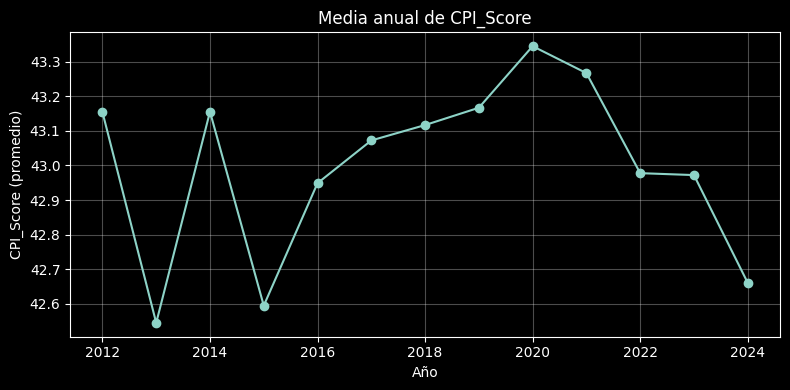


REGISTRO — Variables actualizadas: dict_keys(['ID', 'POR_ANIO', 'FEATURES_BASE', 'TARGETS', 'EDA_KEYS'])


In [19]:
# ==========================================
# PASO 5: EDA mínima (tablas + gráficos opcionales)
# Requiere: df_long_panel del PASO 4
# ==========================================
import pandas as pd
import numpy as np

# 5.1) Países por año
conteo_por_anio = df_long_panel.groupby("Year")["Country"].nunique()
print("Países por año:")
print(conteo_por_anio.to_string())

# 5.2) Resumen CPI_Score por año
resumen_por_anio = df_long_panel.groupby("Year")["CPI_Score"].describe()[
    ["count","mean","std","min","25%","50%","75%","max"]
]
print("\nResumen CPI_Score por año:")
display(resumen_por_anio)

# 5.3) Nulos clave
print("\nNulos clave en LONG:")
print(df_long_panel[["CPI_Score","Sources","Standard_error"]].isna().sum())

# 5.4) Vista rápida por región (si existe)
if "Region" in df_long_panel.columns:
    media_region_ult = (
        df_long_panel[df_long_panel["Year"] == df_long_panel["Year"].max()]
        .groupby("Region")["CPI_Score"]
        .mean()
        .sort_values(ascending=False)
    )
    print("\nMedia CPI_Score por Región (último año disponible):")
    print(media_region_ult.to_string())

# 5.5) (OPCIONAL) Dos gráficos rápidos con fondo negro
MAKE_PLOTS = True  # pon False si no quieres gráficos

if MAKE_PLOTS:
    import matplotlib.pyplot as plt
    plt.style.use('dark_background')

    # Gráfico 2: media anual de CPI_Score
    plt.figure(figsize=(8,4))
    df_long_panel.groupby("Year")["CPI_Score"].mean().plot(marker="o")
    plt.title("Media anual de CPI_Score")
    plt.xlabel("Año")
    plt.ylabel("CPI_Score (promedio)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- Registro ---
if "NOMBRES_VARIABLES" not in globals(): NOMBRES_VARIABLES = {}
NOMBRES_VARIABLES["EDA_KEYS"] = ["conteo_por_anio", "resumen_por_anio", "nulos_clave", "media_region_ult (si aplica)"]
print("\nREGISTRO — Variables actualizadas:", NOMBRES_VARIABLES.keys())


In [20]:
# ==========================================
# PASO 6: Split temporal (train/valid/test)
# Requiere: df_features del PASO 4
# ==========================================
import pandas as pd

# Definimos años (por si ejecutas esta celda sola)
TRAIN_YEARS = list(range(2012, 2022))  # 2012–2021
VALID_YEARS = [2022, 2023]             # Validación
TEST_YEARS  = [2024]                   # Base para predecir 2025

# 6.1) Elimina filas sin target (CPI_Score) antes de partir
df_features_nonull = df_features.dropna(subset=["CPI_Score"]).copy()

# 6.2) Partición temporal
df_train_raw = df_features_nonull[df_features_nonull["Year"].isin(TRAIN_YEARS)].copy()
df_valid_raw = df_features_nonull[df_features_nonull["Year"].isin(VALID_YEARS)].copy()
df_test_raw  = df_features_nonull[df_features_nonull["Year"].isin(TEST_YEARS)].copy()

# 6.3) Chequeos
print("Shapes:")
print("  df_train_raw ->", df_train_raw.shape)
print("  df_valid_raw ->", df_valid_raw.shape)
print("  df_test_raw  ->", df_test_raw.shape)

# Coverage por países (opcional)
print("\nPaíses en TRAIN:", df_train_raw['Country'].nunique())
print("Países en VALID:", df_valid_raw['Country'].nunique())
print("Países en TEST :", df_test_raw['Country'].nunique())

# 6.4) Registro
if "NOMBRES_DATAFRAMES" not in globals(): NOMBRES_DATAFRAMES = []
for nombre in ["df_train_raw", "df_valid_raw", "df_test_raw"]:
    if nombre not in NOMBRES_DATAFRAMES:
        NOMBRES_DATAFRAMES.append(nombre)

if "NOMBRES_VARIABLES" not in globals(): NOMBRES_VARIABLES = {}
NOMBRES_VARIABLES["SPLIT_AÑOS"] = {"TRAIN_YEARS": TRAIN_YEARS, "VALID_YEARS": VALID_YEARS, "TEST_YEARS": TEST_YEARS}

print("\nREGISTRO — DataFrames:", NOMBRES_DATAFRAMES)
print("REGISTRO — SPLIT_AÑOS:", NOMBRES_VARIABLES["SPLIT_AÑOS"])


Shapes:
  df_train_raw -> (1390, 13)
  df_valid_raw -> (359, 13)
  df_test_raw  -> (180, 13)

Países en TRAIN: 180
Países en VALID: 180
Países en TEST : 180

REGISTRO — DataFrames: ['df_wide_raw', 'df_long_panel', 'df_features', 'df_train_raw', 'df_valid_raw', 'df_test_raw']
REGISTRO — SPLIT_AÑOS: {'TRAIN_YEARS': [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], 'VALID_YEARS': [2022, 2023], 'TEST_YEARS': [2024]}


In [21]:
# =====================================================
# PASO 7: Crear objetivo multiclase con terciles globales
# Requiere: df_train_raw, df_valid_raw, df_test_raw
# =====================================================
import numpy as np
import pandas as pd

# 7.1) Calcular terciles SOLO en TRAIN (sin fuga de información)
p33 = df_train_raw["CPI_Score"].quantile(1/3, interpolation="linear")
p66 = df_train_raw["CPI_Score"].quantile(2/3, interpolation="linear")

def cortar_en_terciles(score, p33, p66):
    if pd.isna(score): 
        return np.nan
    if score <= p33:   
        return 0  # bajo
    if score <= p66:   
        return 1  # medio
    return 2            # alto

def etiqueta_texto(c):
    return {0:"bajo", 1:"medio", 2:"alto"}.get(c, np.nan)

# 7.2) Etiquetar TRAIN/VALID/TEST con los mismos cortes
for part in (df_train_raw, df_valid_raw, df_test_raw):
    part["CPI_class"] = part["CPI_Score"].apply(lambda x: cortar_en_terciles(x, p33, p66)).astype("Int64")
    part["CPI_label"] = part["CPI_class"].apply(etiqueta_texto)

print(f"Terciles (calculados en TRAIN): P33={p33:.3f} | P66={p66:.3f}")

# 7.3) Balance de clases (conteo y proporciones)
def resumen_clases(df, nombre):
    print(f"\n{nombre} — distribución de clases (CPI_class):")
    vc = df["CPI_class"].value_counts(dropna=False).sort_index()
    print(vc)
    print("Proporciones (%):")
    print((vc / vc.sum() * 100).round(2))

resumen_clases(df_train_raw, "TRAIN")
resumen_clases(df_valid_raw, "VALID")
resumen_clases(df_test_raw,  "TEST (base 2024)")

# 7.4) Registro de variables en la bitácora
if "NOMBRES_VARIABLES" not in globals(): 
    NOMBRES_VARIABLES = {}
NOMBRES_VARIABLES["TARGETS"] = {
    "continuo": "CPI_Score",
    "clasificacion": {"CPI_class": "0=bajo, 1=medio, 2=alto",
                      "CPI_label": "texto espejo ('bajo','medio','alto')"},
    "terciles_train": {"P33": float(p33), "P66": float(p66)}
}

print("\nREGISTRO — TARGETS:", NOMBRES_VARIABLES["TARGETS"])


Terciles (calculados en TRAIN): P33=32.000 | P66=48.000

TRAIN — distribución de clases (CPI_class):
CPI_class
0    485
1    453
2    452
Name: count, dtype: Int64
Proporciones (%):
CPI_class
0    34.89
1    32.59
2    32.52
Name: count, dtype: Float64

VALID — distribución de clases (CPI_class):
CPI_class
0    114
1    127
2    118
Name: count, dtype: Int64
Proporciones (%):
CPI_class
0    31.75
1    35.38
2    32.87
Name: count, dtype: Float64

TEST (base 2024) — distribución de clases (CPI_class):
CPI_class
0    60
1    58
2    62
Name: count, dtype: Int64
Proporciones (%):
CPI_class
0    33.33
1    32.22
2    34.44
Name: count, dtype: Float64

REGISTRO — TARGETS: {'continuo': 'CPI_Score', 'clasificacion': {'CPI_class': '0=bajo, 1=medio, 2=alto', 'CPI_label': "texto espejo ('bajo','medio','alto')"}, 'terciles_train': {'P33': 32.0, 'P66': 48.0}}


In [22]:
# ==========================================
# PASO 8: Definir X e y (features y objetivo)
# Requiere: df_train_raw, df_valid_raw con CPI_class ya creado
# ==========================================


# 8.1) Lista de FEATURES y TARGET (coherente con lo construido)
FEATURES = [
    "Sources", "Standard_error",
    "CPI_Score_lag1", "CPI_Score_lag2", "delta1",
    "flag_imputed_Sources", "flag_imputed_SE"
]
TARGET = "CPI_class"

# 8.2) Checks de existencia de columnas
faltan_train = [c for c in FEATURES+[TARGET] if c not in df_train_raw.columns]
faltan_valid = [c for c in FEATURES+[TARGET] if c not in df_valid_raw.columns]
if faltan_train or faltan_valid:
    raise ValueError(f"Faltan columnas en TRAIN: {faltan_train} | en VALID: {faltan_valid}")

# 8.3) Dropear filas con NaN en features/target (seguridad)
df_train = df_train_raw.dropna(subset=FEATURES+[TARGET]).copy()
df_valid = df_valid_raw.dropna(subset=FEATURES+[TARGET]).copy()

# 8.4) Construir matrices X/y
X_train = df_train[FEATURES].copy()
y_train = df_train[TARGET].astype(int).copy()

X_valid = df_valid[FEATURES].copy()
y_valid = df_valid[TARGET].astype(int).copy()

# 8.5) Reporte rápido y registro
print("Shapes X/y:")
print("  X_train ->", X_train.shape, "| y_train ->", y_train.shape)
print("  X_valid ->", X_valid.shape, "| y_valid ->", y_valid.shape)

if "NOMBRES_DATAFRAMES" not in globals(): NOMBRES_DATAFRAMES = []
for nombre in ["df_train", "df_valid"]:
    if nombre not in NOMBRES_DATAFRAMES:
        NOMBRES_DATAFRAMES.append(nombre)

if "NOMBRES_VARIABLES" not in globals(): NOMBRES_VARIABLES = {}
NOMBRES_VARIABLES["FEATURES_USED"] = FEATURES
NOMBRES_VARIABLES["TARGET_USED"] = TARGET

print("\nREGISTRO — DataFrames:", NOMBRES_DATAFRAMES)
print("REGISTRO — FEATURES_USED:", NOMBRES_VARIABLES["FEATURES_USED"])
print("REGISTRO — TARGET_USED:", NOMBRES_VARIABLES["TARGET_USED"])


Shapes X/y:
  X_train -> (1390, 7) | y_train -> (1390,)
  X_valid -> (359, 7) | y_valid -> (359,)

REGISTRO — DataFrames: ['df_wide_raw', 'df_long_panel', 'df_features', 'df_train_raw', 'df_valid_raw', 'df_test_raw', 'df_train', 'df_valid']
REGISTRO — FEATURES_USED: ['Sources', 'Standard_error', 'CPI_Score_lag1', 'CPI_Score_lag2', 'delta1', 'flag_imputed_Sources', 'flag_imputed_SE']
REGISTRO — TARGET_USED: CPI_class


In [23]:
# ==========================================
# PASO 9: Entrenar RF y evaluar en VALID
# Requiere: X_train, y_train, X_valid, y_valid (PASO 8)
# ==========================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    balanced_accuracy_score, f1_score, classification_report,
    confusion_matrix, cohen_kappa_score
)

SEED = 42

rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=SEED,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_val_pred = rf_model.predict(X_valid)
y_val_prob = rf_model.predict_proba(X_valid)

bal_acc  = balanced_accuracy_score(y_valid, y_val_pred)
f1_macro = f1_score(y_valid, y_val_pred, average='macro')
qwk      = cohen_kappa_score(y_valid, y_val_pred, weights='quadratic')
cm       = confusion_matrix(y_valid, y_val_pred, labels=[0,1,2])

print("=== MÉTRICAS VALIDACIÓN (2022–2023) ===")
print(f"Balanced Accuracy : {bal_acc:.4f}")
print(f"F1-macro          : {f1_macro:.4f}")
print(f"QWK (quadratic)   : {qwk:.4f}")
print("\nMatriz de confusión (filas=verdadero, columnas=predicho) [0=bajo,1=medio,2=alto]:")
print(cm)

print("\nReporte de clasificación:")
print(classification_report(y_valid, y_val_pred, target_names=['bajo','medio','alto']))

# Registro de métricas
METRICAS_VALID = {
    "balanced_accuracy": float(bal_acc),
    "f1_macro": float(f1_macro),
    "qwk": float(qwk),
    "confusion_matrix": cm.tolist()
}

# Bitácora
if "NOMBRES_VARIABLES" not in globals(): NOMBRES_VARIABLES = {}
NOMBRES_VARIABLES["METRICAS_VALID"] = METRICAS_VALID
print("\nREGISTRO — METRICAS_VALID:", NOMBRES_VARIABLES["METRICAS_VALID"])


=== MÉTRICAS VALIDACIÓN (2022–2023) ===
Balanced Accuracy : 0.9675
F1-macro          : 0.9669
QWK (quadratic)   : 0.9744

Matriz de confusión (filas=verdadero, columnas=predicho) [0=bajo,1=medio,2=alto]:
[[112   2   0]
 [  4 119   4]
 [  0   2 116]]

Reporte de clasificación:
              precision    recall  f1-score   support

        bajo       0.97      0.98      0.97       114
       medio       0.97      0.94      0.95       127
        alto       0.97      0.98      0.97       118

    accuracy                           0.97       359
   macro avg       0.97      0.97      0.97       359
weighted avg       0.97      0.97      0.97       359


REGISTRO — METRICAS_VALID: {'balanced_accuracy': 0.9675049539414174, 'f1_macro': 0.9669009864815492, 'qwk': 0.974354089772592, 'confusion_matrix': [[112, 2, 0], [4, 119, 4], [0, 2, 116]]}


Importancia de variables (RF):
                feature  importance
0        CPI_Score_lag1    0.531929
1        CPI_Score_lag2    0.418797
2        Standard_error    0.018850
3               Sources    0.017422
4                delta1    0.013002
5  flag_imputed_Sources    0.000000
6       flag_imputed_SE    0.000000


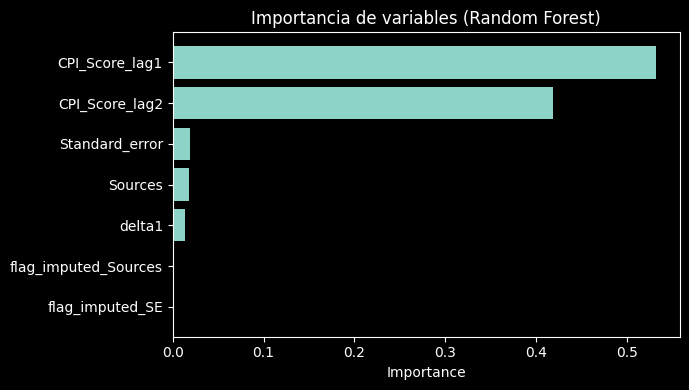


Matriz de confusión (DataFrame):
            PRED_bajo  PRED_medio  PRED_alto
                                            
TRUE_bajo         112           2          0
TRUE_medio          4         119          4
TRUE_alto           0           2        116

REGISTRO — KEYS actualizadas: ['ID', 'POR_ANIO', 'FEATURES_BASE', 'TARGETS', 'EDA_KEYS', 'SPLIT_AÑOS', 'FEATURES_USED', 'TARGET_USED', 'METRICAS_VALID', 'FEATURE_IMPORTANCE']


In [24]:
# ======================================================
# PASO 10: Diagnóstico (importancia de features + CM legible)
# Requiere: rf_model, FEATURES, y_valid, y_val_pred (del PASO 9)
# ======================================================
import pandas as pd

# 10.1) Importancia de variables
importances = pd.DataFrame({
    "feature": FEATURES,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False).reset_index(drop=True)

print("Importancia de variables (RF):")
print(importances)

# (OPCIONAL) gráfico rápido con fondo negro
MAKE_PLOTS = True
if MAKE_PLOTS:
    import matplotlib.pyplot as plt
    plt.style.use('dark_background')
    plt.figure(figsize=(7,4))
    plt.barh(importances["feature"], importances["importance"])
    plt.gca().invert_yaxis()
    plt.title("Importancia de variables (Random Forest)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# 10.2) Matriz de confusión en DataFrame con etiquetas
from sklearn.metrics import confusion_matrix
cm_df = pd.DataFrame(
    confusion_matrix(y_valid, y_val_pred, labels=[0,1,2]),
    index=pd.Index(['TRUE_bajo','TRUE_medio','TRUE_alto'], name=''),
    columns=pd.Index(['PRED_bajo','PRED_medio','PRED_alto'], name='')
)
print("\nMatriz de confusión (DataFrame):")
print(cm_df)

# Bitácora (registro)
if "NOMBRES_VARIABLES" not in globals(): 
    NOMBRES_VARIABLES = {}
NOMBRES_VARIABLES["FEATURE_IMPORTANCE"] = importances.to_dict(orient="list")
print("\nREGISTRO — KEYS actualizadas:", list(NOMBRES_VARIABLES.keys()))


In [25]:
# ======================================================
# PASO 11: Scoring 2025 (usar 2024 como base)
# Requiere: df_test_raw (base 2024), FEATURES, rf_model
# ======================================================
import pandas as pd
import numpy as np

# 11.1) Checks
faltan_cols_test = [c for c in FEATURES if c not in df_test_raw.columns]
if faltan_cols_test:
    raise ValueError(f"Faltan columnas en df_test_raw: {faltan_cols_test}")

# 11.2) Matriz de features de TEST (2024)
X_test = df_test_raw[FEATURES].copy()

# 11.3) Predicciones de clase y probabilidades para 2025
pred_class_2025 = rf_model.predict(X_test)
pred_prob_2025  = rf_model.predict_proba(X_test)

# 11.4) Tabla final de predicciones
preds_2025 = pd.DataFrame({
    "Country":    df_test_raw["Country"].values,
    "ISO3":       df_test_raw["ISO3"].values,
    "Region":     df_test_raw["Region"].values,
    "Year_base":  df_test_raw["Year"].values,     # 2024
    "Pred_Class_2025": pred_class_2025,
    "Pred_Label_2025": pd.Series(pred_class_2025).map({0:"bajo",1:"medio",2:"alto"}),
    "Proba_bajo":  pred_prob_2025[:, 0],
    "Proba_medio": pred_prob_2025[:, 1],
    "Proba_alto":  pred_prob_2025[:, 2],
})

print("Predicciones 2025 (primeras 10 filas):")
print(preds_2025.head(10).to_string(index=False))

# 11.5) Registro
if "NOMBRES_DATAFRAMES" not in globals(): NOMBRES_DATAFRAMES = []
if "preds_2025" not in NOMBRES_DATAFRAMES:
    NOMBRES_DATAFRAMES.append("preds_2025")

print("\nREGISTRO — DataFrames:", NOMBRES_DATAFRAMES)


Predicciones 2025 (primeras 10 filas):
    Country ISO3 Region  Year_base  Pred_Class_2025 Pred_Label_2025  Proba_bajo  Proba_medio  Proba_alto
Afghanistan  AFG     AP       2024                0            bajo    0.979378     0.012790    0.007831
    Albania  ALB    ECA       2024                1           medio    0.062995     0.924172    0.012834
    Algeria  DZA   MENA       2024                1           medio    0.056841     0.935474    0.007686
     Angola  AGO    SSA       2024                1           medio    0.238476     0.758082    0.003442
  Argentina  ARG    AME       2024                1           medio    0.032541     0.958218    0.009241
    Armenia  ARM    ECA       2024                1           medio    0.009211     0.891927    0.098861
  Australia  AUS     AP       2024                2            alto    0.000000     0.001499    0.998501
    Austria  AUT  WE/EU       2024                2            alto    0.000667     0.000938    0.998395
 Azerbaijan  AZE

=== ROC–AUC (VALID) ===
AUC clase 0 (bajo): 0.9972
AUC clase 1 (medio): 0.9927
AUC clase 2 (alto): 0.9990
AUC micro-promedio: 0.9966
AUC macro-promedio: 0.9968


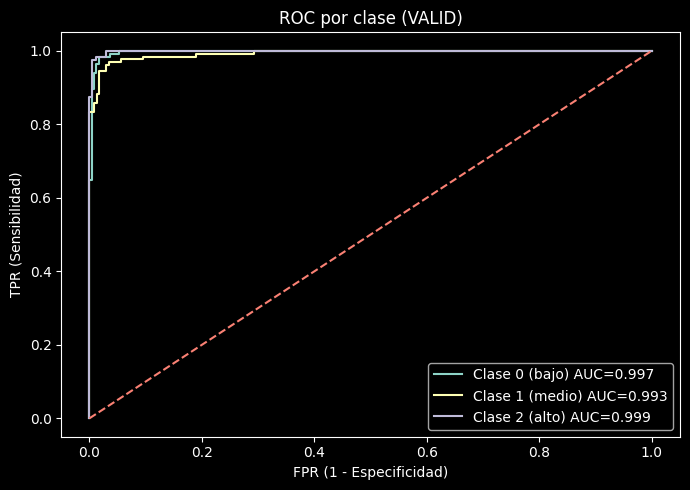

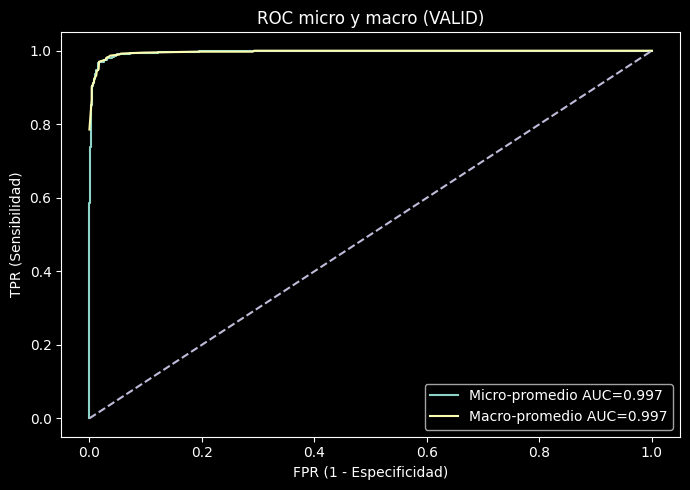


REGISTRO — ROC_VALID: {'AUC_clase_0_bajo': 0.9972431077694235, 'AUC_clase_1_medio': 0.9926690198207984, 'AUC_clase_2_alto': 0.9989802377101062, 'AUC_micro': 0.9965859979360805, 'AUC_macro': 0.9967862986462674}


In [26]:
# ======================================================
# PASO 13: ROC–AUC multiclase (VALID)
# Requiere: y_valid, y_val_prob, y_val_pred, rf_model del PASO 9
# ======================================================
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# 13.1) Binarizar y (one-vs-rest) para 3 clases: 0=bajo,1=medio,2=alto
clases = np.array([0, 1, 2])
y_valid_bin = label_binarize(y_valid, classes=clases)  # shape (n_muestras, 3)

# 13.2) Curvas ROC por clase y AUC por clase
fpr, tpr, roc_auc = {}, {}, {}
for i, c in enumerate(clases):
    fpr[c], tpr[c], _ = roc_curve(y_valid_bin[:, i], y_val_prob[:, i])
    roc_auc[c] = auc(fpr[c], tpr[c])

# 13.3) Micro y macro promedio
# micro: trata todas las etiquetas como un vector único
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid_bin.ravel(), y_val_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro: promedio de las TPRs interpoladas en una malla común de FPR
all_fpr = np.unique(np.concatenate([fpr[c] for c in clases]))
mean_tpr = np.zeros_like(all_fpr)
for c in clases:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
mean_tpr /= len(clases)
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 13.4) Imprimir AUCs
print("=== ROC–AUC (VALID) ===")
for c in clases:
    print(f"AUC clase {c} ({['bajo','medio','alto'][c]}): {roc_auc[c]:.4f}")
print(f"AUC micro-promedio: {roc_auc['micro']:.4f}")
print(f"AUC macro-promedio: {roc_auc['macro']:.4f}")

# 13.5) (OPCIONAL) Graficar ROC por clase + micro y macro
MAKE_PLOTS = True
if MAKE_PLOTS:
    plt.style.use('dark_background')  # fondo negro como antes

    # a) ROC por clase
    plt.figure(figsize=(7,5))
    for c in clases:
        plt.plot(fpr[c], tpr[c], label=f"Clase {c} ({['bajo','medio','alto'][c]}) AUC={roc_auc[c]:.3f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("FPR (1 - Especificidad)")
    plt.ylabel("TPR (Sensibilidad)")
    plt.title("ROC por clase (VALID)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # b) ROC micro y macro
    plt.figure(figsize=(7,5))
    plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-promedio AUC={roc_auc['micro']:.3f}")
    plt.plot(fpr["macro"], tpr["macro"], label=f"Macro-promedio AUC={roc_auc['macro']:.3f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("FPR (1 - Especificidad)")
    plt.ylabel("TPR (Sensibilidad)")
    plt.title("ROC micro y macro (VALID)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# 13.6) Registrar en bitácora
if "NOMBRES_VARIABLES" not in globals():
    NOMBRES_VARIABLES = {}
NOMBRES_VARIABLES["ROC_VALID"] = {
    "AUC_clase_0_bajo":  float(roc_auc[0]),
    "AUC_clase_1_medio": float(roc_auc[1]),
    "AUC_clase_2_alto":  float(roc_auc[2]),
    "AUC_micro":         float(roc_auc["micro"]),
    "AUC_macro":         float(roc_auc["macro"])
}
print("\nREGISTRO — ROC_VALID:", NOMBRES_VARIABLES["ROC_VALID"])


In [28]:
# ==========================================
# PASO 16: Autocorrelación y distancia a umbrales
# ==========================================
import numpy as np

# 16.1) Correlación CPI vs lag1 en VALID
corr_val = df_valid[["CPI_Score","CPI_Score_lag1"]].dropna().corr().iloc[0,1]
print(f"Correlación (VALID) CPI_Score vs CPI_Score_lag1: {corr_val:.3f}")

# 16.2) Distancia mínima a umbrales (d_min)
def dmin(score, p33, p66):
    if np.isnan(score): return np.nan
    return min(abs(score - p33), abs(score - p66))

tmp = df_valid.copy()
tmp["d_min"] = tmp["CPI_Score"].apply(lambda x: dmin(x, p33, p66))

tmp["acierto"] = (y_valid.values == y_val_pred).astype(int)
print("\nDistancia a umbrales (promedios):")
print("  Aciertos:", tmp.loc[tmp["acierto"]==1, "d_min"].mean())
print("  Errores :", tmp.loc[tmp["acierto"]==0, "d_min"].mean())


Correlación (VALID) CPI_Score vs CPI_Score_lag1: 0.996

Distancia a umbrales (promedios):
  Aciertos: 10.244956772334294
  Errores : 1.9166666666666667


In [29]:
# ==========================================
# PASO 17: Brier score multicase y (opcional) curva de confiabilidad
# ==========================================
import numpy as np
from sklearn.preprocessing import label_binarize

# Brier multicase (promedio de sum_k (p_k - y_k)^2 )
clases = np.array([0,1,2])
Y_onehot = label_binarize(y_valid, classes=clases)  # (n,3)

brier = np.mean(np.sum((y_val_prob - Y_onehot)**2, axis=1))
print(f"Brier score (VALID, menor=mejor): {brier:.4f}")

# (Opcional) Curva de confiabilidad por clase
MAKE_PLOTS = False  # pon True si quieres ver los gráficos
if MAKE_PLOTS:
    import matplotlib.pyplot as plt
    plt.style.use('dark_background')
    from sklearn.calibration import calibration_curve

    for i, name in enumerate(['bajo','medio','alto']):
        prob_true, prob_pred = calibration_curve((y_valid==i).astype(int), y_val_prob[:,i], n_bins=10, strategy='uniform')
        plt.figure(figsize=(5,4))
        plt.plot(prob_pred, prob_true, marker='o', label=f'Clase {name}')
        plt.plot([0,1],[0,1],'--', alpha=0.6)
        plt.title(f'Confiabilidad – clase {name}')
        plt.xlabel('Probabilidad predicha')
        plt.ylabel('Frecuencia observada')
        plt.tight_layout()
        plt.show()


Brier score (VALID, menor=mejor): 0.0575


In [30]:
# ==========================================
# PASO 18: Entrenamiento con OOB para comparar
# ==========================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

rf_oob = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    oob_score=True
)
rf_oob.fit(X_train, y_train)

print(f"OOB score (RF): {rf_oob.oob_score_:.4f}")   # es accuracy simple
# Comparación rápida con VALID (balanced accuracy ya la tienes)


OOB score (RF): 0.9482


In [31]:
# ==========================================
# PASO 19: KS test Train vs Valid por feature
# ==========================================
from scipy.stats import ks_2samp

print("KS test (Train vs Valid) por feature:")
for f in FEATURES:
    a = df_train[f].dropna().values
    b = df_valid[f].dropna().values
    stat, p = ks_2samp(a, b)
    print(f"{f:>20s}  KS={stat:.3f}  p={p:.3g}")


KS test (Train vs Valid) por feature:
             Sources  KS=0.051  p=0.438
      Standard_error  KS=0.298  p=7.42e-23
      CPI_Score_lag1  KS=0.040  p=0.724
      CPI_Score_lag2  KS=0.054  p=0.358
              delta1  KS=0.060  p=0.242
flag_imputed_Sources  KS=0.000  p=1
     flag_imputed_SE  KS=0.000  p=1


In [32]:
# ==========================================
# PASO 20: Brier baseline + Brier Skill Score (BSS)
# Usa las frecuencias de clases en TRAIN como baseline
# ==========================================
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize

# Frecuencias de clase SOLO en TRAIN (sin fuga)
freq_train = (
    df_train_raw["CPI_class"]
    .value_counts(normalize=True)
    .sort_index()
    .reindex([0,1,2], fill_value=0.0)
)
print("Frecuencias TRAIN:", freq_train.to_dict())

# One-hot de y_valid
clases = np.array([0,1,2])
Y_onehot = label_binarize(y_valid, classes=clases)  # (n,3)

# Matriz de probs baseline (misma fila = frecuencias TRAIN)
P_base = np.tile(freq_train.values, (Y_onehot.shape[0], 1))

# Brier baseline (climatología)
brier_base = np.mean(np.sum((P_base - Y_onehot)**2, axis=1))
print(f"Brier baseline (climatología TRAIN): {brier_base:.4f}")

# Brier del modelo (ya lo calculaste como 0.0575; lo recalculo por robustez)
brier_model = np.mean(np.sum((y_val_prob - Y_onehot)**2, axis=1))
print(f"Brier modelo (VALID): {brier_model:.4f}")

# Brier Skill Score (1 - modelo/baseline); más alto = mejor
bss = 1.0 - (brier_model / brier_base)
print(f"Brier Skill Score (BSS): {bss:.4f}")


Frecuencias TRAIN: {0: 0.3489208633093525, 1: 0.3258992805755396, 2: 0.3251798561151079}
Brier baseline (climatología TRAIN): 0.6678
Brier modelo (VALID): 0.0575
Brier Skill Score (BSS): 0.9139
